In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/ETH-USD.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()


Date
2021-02-10    1744.243408
2021-02-11    1783.797974
2021-02-12    1843.532593
2021-02-13    1814.109863
2021-02-14    1805.084106
Name: Close, dtype: float64

In [2]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

# [[YOUR CODE]]
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)



### ADF 검정의 귀무가설은 DF 검정과 귀무가설이 같으므로 검정통계량이 Critical Value보다 작거나 p-value가 설정한 유의수준 값보다 작으면 정상적인 시계열 데이터라고 볼 수 있어요.

 

In [3]:
# 가장 먼저 고려해 볼 수 있는 것은 시간 추이에 따라 분산이 점점 커지고 있다는 점입니다. 
# 시계열이 이런 특성을 보일 경우에는 로그함수로 변환을 해주는 것이 도움이 됩니다.
# 로그 변환 시도 

ts_log = np.log(ts)


In [20]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.833985
p-value                          0.363724
#Lags Used                       1.000000
Number of Observations Used    364.000000
Critical Value (1%)             -3.448443
Critical Value (5%)             -2.869513
Critical Value (10%)            -2.571018
dtype: float64


### p-value가 0.36으로 무려 절반 이상 줄어들었습니다. 
### 정성적으로도 시간 추이에 따른 분산이 일정해진 것을 확인할 수 있습니다. 
### 아주 효과적인 변환이었던 것 같습니다. 
### 문제점은 시간 추이에 따라 평균이 계속 증가한다는 점입니다.

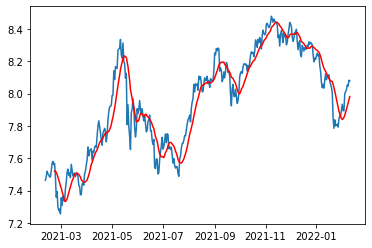

In [21]:
moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

### 시계열 분석에서 위와 같이 시간 추이에 따라 나타나는 평균값 변화를 추세(trend)라고 합니다

In [22]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(15)

Date
2021-02-10         NaN
2021-02-11         NaN
2021-02-12         NaN
2021-02-13         NaN
2021-02-14         NaN
2021-02-15         NaN
2021-02-16         NaN
2021-02-17         NaN
2021-02-18         NaN
2021-02-19         NaN
2021-02-20         NaN
2021-02-21    0.048092
2021-02-22   -0.036378
2021-02-23   -0.152277
2021-02-24   -0.106571
Name: Close, dtype: float64

In [23]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Date
2021-02-21    0.048092
2021-02-22   -0.036378
2021-02-23   -0.152277
2021-02-24   -0.106571
2021-02-25   -0.186708
2021-02-26   -0.188537
2021-02-27   -0.162437
2021-02-28   -0.173872
2021-03-01   -0.060156
2021-03-02   -0.085593
2021-03-03   -0.013135
2021-03-04   -0.016653
2021-03-05   -0.002854
2021-03-06    0.079559
2021-03-07    0.112325
Name: Close, dtype: float64

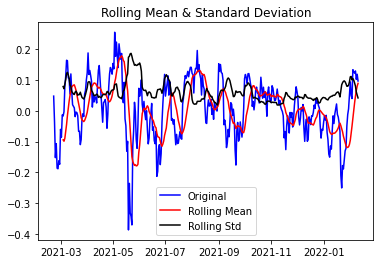

In [24]:
plot_rolling_statistics(ts_log_moving_avg)

In [25]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                -6.109814e+00
p-value                        9.391859e-08
#Lags Used                     7.000000e+00
Number of Observations Used    3.470000e+02
Critical Value (1%)           -3.449337e+00
Critical Value (5%)           -2.869906e+00
Critical Value (10%)          -2.571227e+00
dtype: float64


### p value 로 9로 오히려 증가함을 확인하였다  



In [38]:
moving_avg_7 = ts_log.rolling(window=7).mean()
ts_log_moving_avg_7 = ts_log - moving_avg_7
ts_log_moving_avg_7.dropna(inplace=True)
print('슝=3')

슝=3


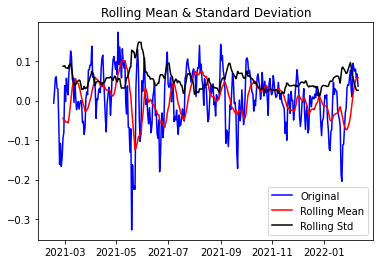

In [39]:
plot_rolling_statistics(ts_log_moving_avg_7)

In [40]:
augmented_dickey_fuller_test(ts_log_moving_avg_7)

Results of Dickey-Fuller Test:
Test Statistic                -5.953643e+00
p-value                        2.118247e-07
#Lags Used                     5.000000e+00
Number of Observations Used    3.540000e+02
Critical Value (1%)           -3.448958e+00
Critical Value (5%)           -2.869739e+00
Critical Value (10%)          -2.571138e+00
dtype: float64


### Augmented Dickey-Fuller Test의 결과 p-value는 2.11 수준이어서 
###  아직도 안정적 시계열이라고 말할 수 없게 되었습니다.
### 이 데이터셋은 일별이기 때문에 7일= 일주일이라, windows = 7 으로 두었다. 

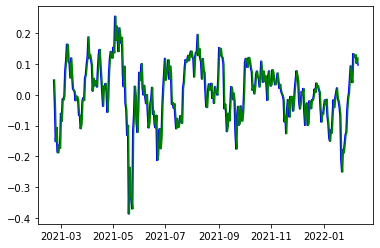

In [41]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

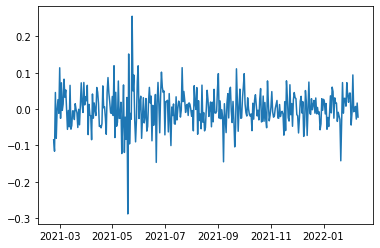

In [42]:
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

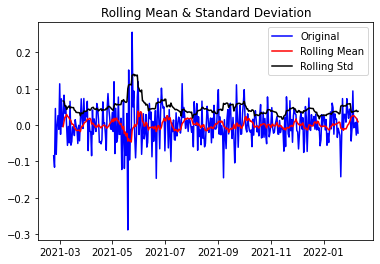

In [43]:
plot_rolling_statistics(ts_log_moving_avg_diff)

In [44]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                -7.212877e+00
p-value                        2.211317e-10
#Lags Used                     1.500000e+01
Number of Observations Used    3.380000e+02
Critical Value (1%)           -3.449846e+00
Critical Value (5%)           -2.870129e+00
Critical Value (10%)          -2.571346e+00
dtype: float64


### 이동평균을 빼 주어 추세(Trend)를 제거하고 난 시계열에다가
### 1차 차분(1st order differencing)을 적용하여 Seasonality 효과를 다소 상쇄한 결과, 
### p-value가 약 2.11 에서 2.21로 오히려 늘었습니다 



# 시계열 분해(Time Series Decomposition)


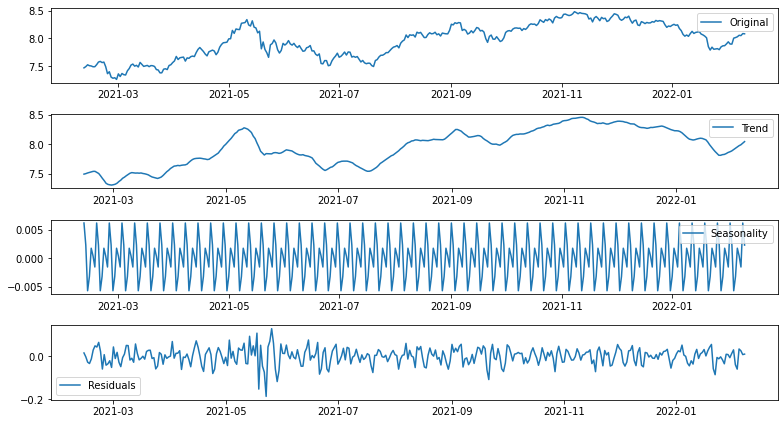

In [45]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [26]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


### statsmodels 패키지에서 제공하는 adfuller 메서드를 이용해 
### 주어진 timeseries에 대한 Augmented Dickey-Fuller Test를 수행하는 코드입니다.

In [27]:
# statsmodels 패키지에서 제공하는 adfuller 메서드를 이용해 
# 주어진 timeseries에 대한 Augmented Dickey-Fuller Test를 수행하는 코드입니다.

from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


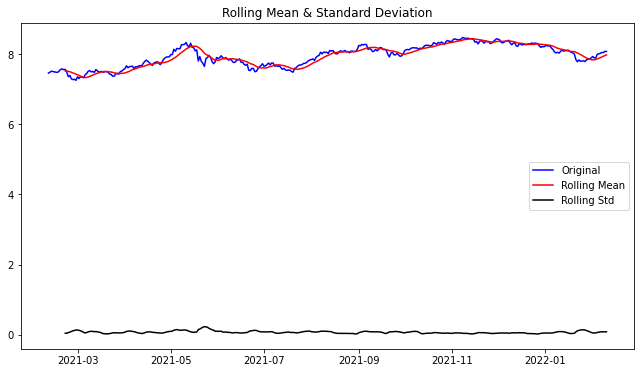

Results of Dickey-Fuller Test:
Test Statistic                  -1.833985
p-value                          0.363724
#Lags Used                       1.000000
Number of Observations Used    364.000000
Critical Value (1%)             -3.448443
Critical Value (5%)             -2.869513
Critical Value (10%)            -2.571018
dtype: float64


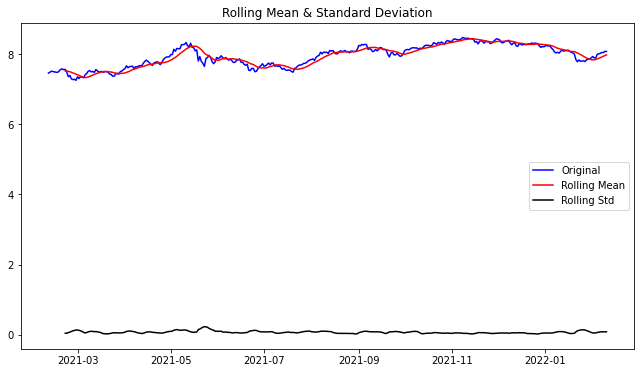

Results of Dickey-Fuller Test:
Test Statistic                  -1.833985
p-value                          0.363724
#Lags Used                       1.000000
Number of Observations Used    364.000000
Critical Value (1%)             -3.448443
Critical Value (5%)             -2.869513
Critical Value (10%)            -2.571018
dtype: float64


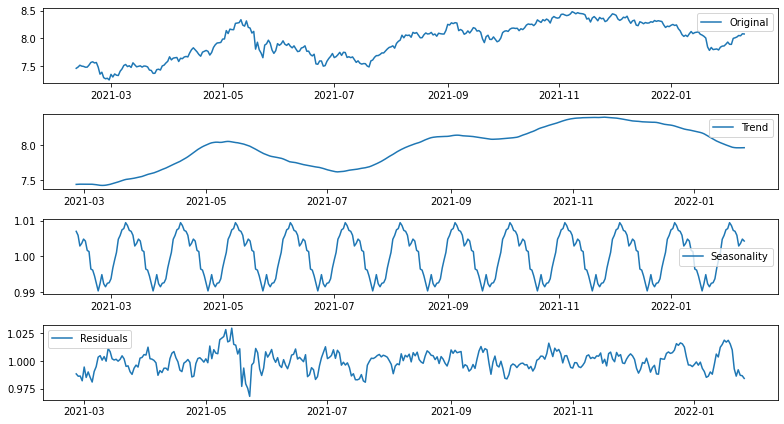

In [46]:
from statsmodels.tsa.stattools import adfuller

# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
# [[YOUR CODE]]

#검정을 통해 귀무가설을 기각하면 정상성을 띤다고 볼 수 있어요.
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


### decomposing 으로 얻어진 residual 은 압도적으로 낮은 p-value을 보여줍니다. (2.1-->0.36)


In [47]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)
# [[YOUR CODE]]

Results of Dickey-Fuller Test:
Test Statistic                -7.354751e+00
p-value                        9.847122e-11
#Lags Used                     7.000000e+00
Number of Observations Used    3.280000e+02
Critical Value (1%)           -3.450445e+00
Critical Value (5%)           -2.870392e+00
Critical Value (10%)          -2.571486e+00
dtype: float64


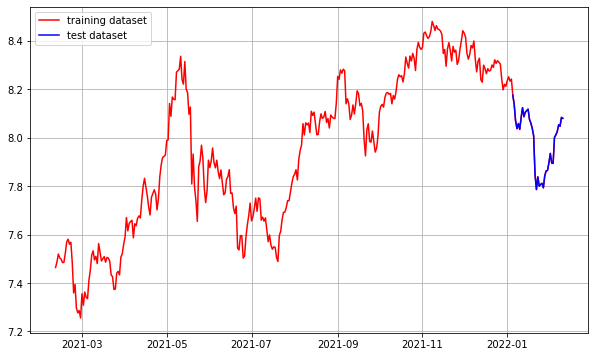

In [48]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [58]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2021-02-10    7.464076
2021-02-11    7.486500
Name: Close, dtype: float64
(329,)
(37,)


# ARIMA를 효과적으로 활용하기 위해서는 

# ARIMA의 모수(parameter)를 잘 설정해야 합니다


## ACF를 통해 이동평균 모형 MA 모델의 시차 'q'를 결정하고, 

## PACF를 통해 자기회귀 모형 AR 모델의 시차 'p'를 결정할 수 있음



/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


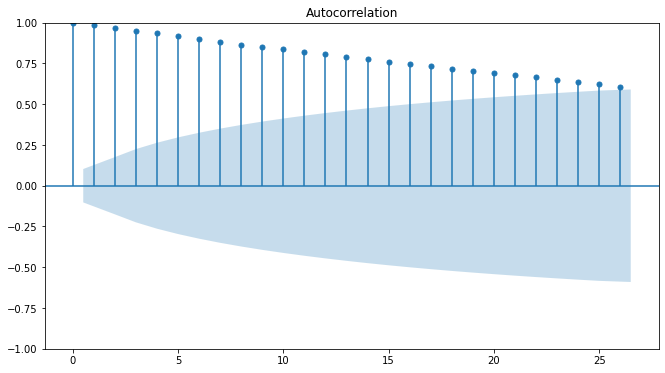

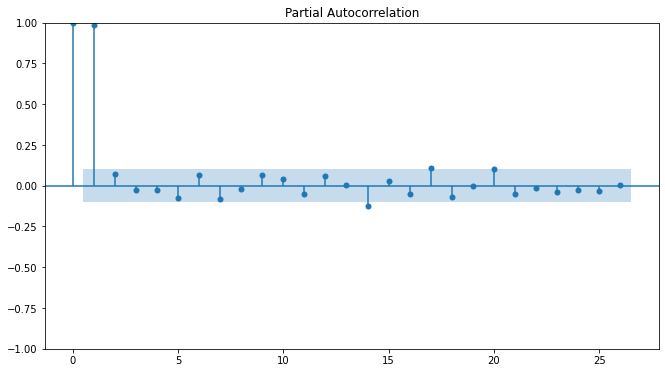

In [49]:
# ACF, PACF 그려보기 -> p,q 구하기 모수(p,d,q)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

# [[YOUR CODE]]

# pacf 그래프를 볼 때, p =1 이 적합합니다

## 왜냐하면, P=2 이상인 구간에서 PACF 는 거의 0 에 가까워지고 있기 때문입니다

### PACF가 0이라는 의미는 현재 데이터와 p 시점 떨어진 이전의 데이터는 상관도가 0, 즉 아무 상관 없는 데이터이기 때문에 고려할 필요가 없다는 뜻입니다.

### 반면 ACF는 점차적으로 감소하고 있어서 AR(1) 모델에 유사한 형태를 보이고 있습니다. q에 대해서는 적합한 값이 없어 보입니다. MA를 고려할 필요가 없다면 q=0으로 둘 수 있습니다. 하지만 q를 바꿔 가면서 확인해 보는 것도 좋겠습니다.

### 아래 p 값 결과로 d = 1 , 1차 차분이 낫다는 판단을 내렸다


Results of Dickey-Fuller Test:
Test Statistic                 -20.521969
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    364.000000
Critical Value (1%)             -3.448443
Critical Value (5%)             -2.869513
Critical Value (10%)            -2.571018
dtype: float64


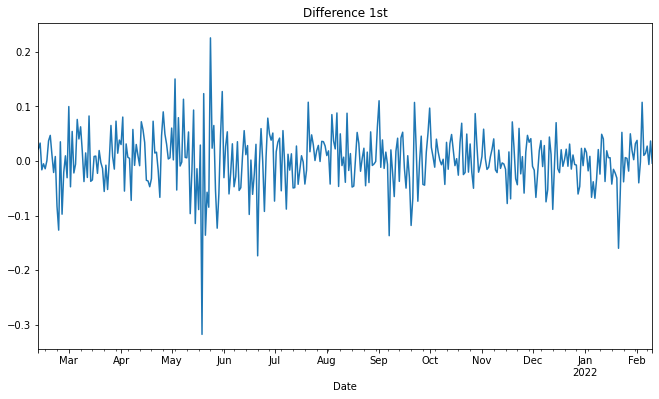

In [54]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -7.832722e+00
p-value                        6.230756e-12
#Lags Used                     1.500000e+01
Number of Observations Used    3.480000e+02
Critical Value (1%)           -3.449282e+00
Critical Value (5%)           -2.869881e+00
Critical Value (10%)          -2.571214e+00
dtype: float64
------------------------------------------------------------------------------------------


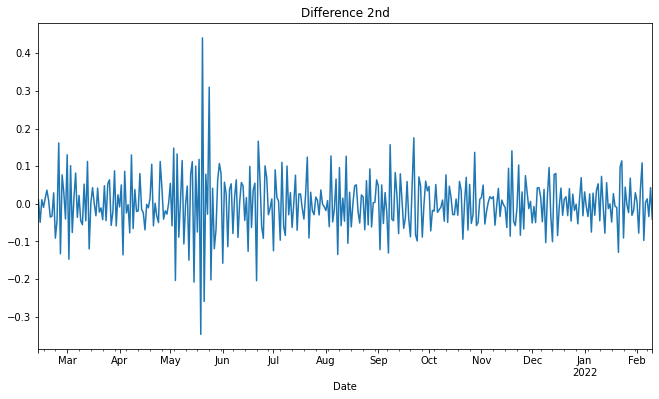

In [55]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)
print('-'*90)

Results of Dickey-Fuller Test:
Test Statistic                -9.670666e+00
p-value                        1.279505e-16
#Lags Used                     1.600000e+01
Number of Observations Used    3.460000e+02
Critical Value (1%)           -3.449392e+00
Critical Value (5%)           -2.869930e+00
Critical Value (10%)          -2.571240e+00
dtype: float64
------------------------------------------------------------------------------------------


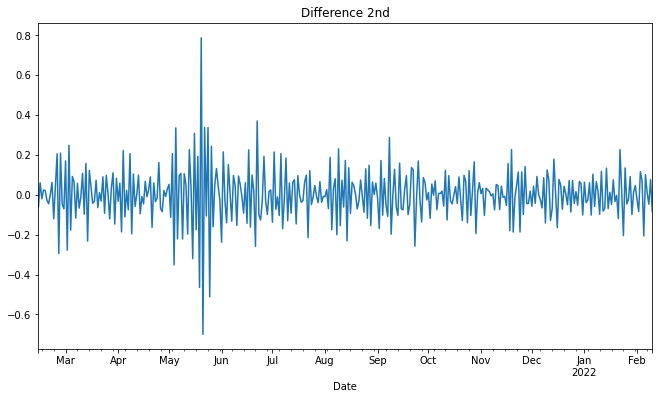

In [56]:
# 혹시 필요한 경우 2차 차분 구하기
diff_3 = diff_2.diff(periods=1).iloc[1:]
diff_3.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_3)
print('-'*90)

Results of Dickey-Fuller Test:
Test Statistic                -1.113605e+01
p-value                        3.193407e-20
#Lags Used                     1.700000e+01
Number of Observations Used    3.440000e+02
Critical Value (1%)           -3.449503e+00
Critical Value (5%)           -2.869979e+00
Critical Value (10%)          -2.571266e+00
dtype: float64
------------------------------------------------------------------------------------------


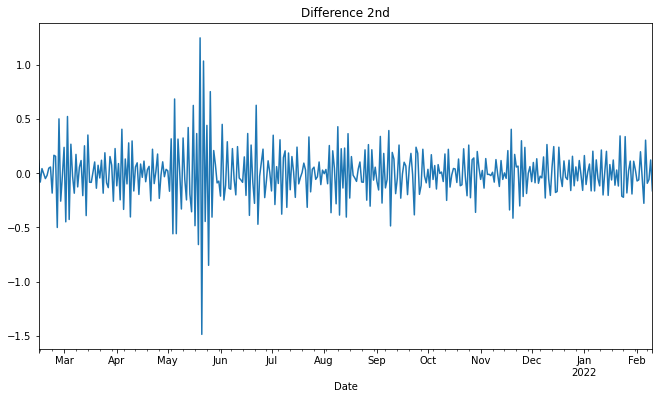

In [57]:
# 혹시 필요한 경우 2차 차분 구하기
diff_4 = diff_3.diff(periods=1).iloc[1:]
diff_4.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_4)
print('-'*90)

In [ ]:
## ARIMA 모델 훈련하기


In [59]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model

model = ARIMA(train_data, order=(2, 1, 1))  

# order=(p,d,q) 
#p : 자기회귀 모형(AR)의 시차
# d : 차분 누적(I) 횟수
#q : 이동평균 모형(MA)의 시차
    
fitted_m = model.fit() 

print(fitted_m.summary())



                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  329
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 501.684
Date:                Thu, 10 Feb 2022   AIC                           -995.367
Time:                        04:07:25   BIC                           -980.195
Sample:                    02-10-2021   HQIC                          -989.314
                         - 01-04-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3115      0.957     -0.325      0.745      -2.187       1.564
ar.L2          0.0184      0.105      0.175      0.861      -0.187       0.224
ma.L1          0.2197      0.968      0.227      0.8

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelih

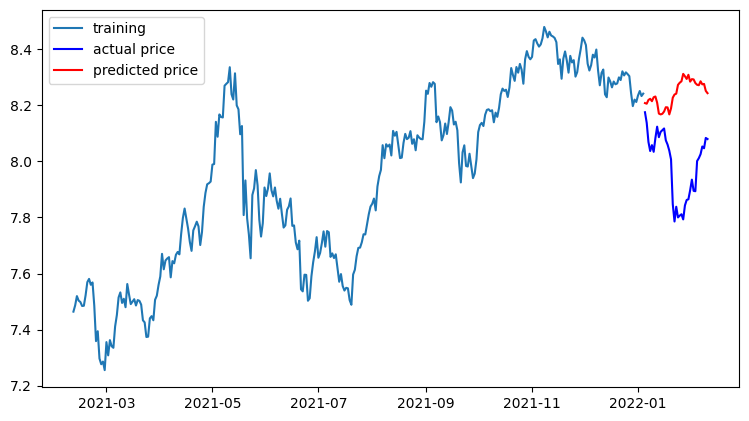

In [71]:
model = ARIMA(train_data, order=(108, 1, 0))  # p값을 18으로 테스트
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

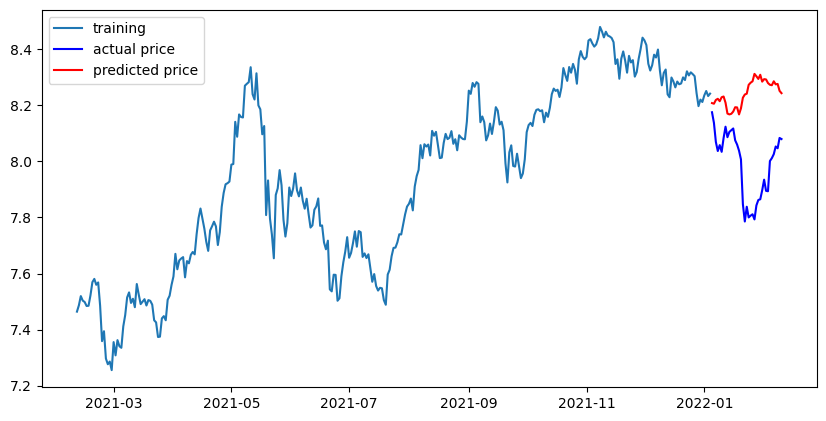

In [72]:
# Forecast : 결과가 fc에 담깁니다. 
# [[YOUR CODE]]# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

# Make as pandas series
# [[YOUR CODE]]

# Plot
# [[YOUR CODE]]

In [74]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  925354.2163473436
MAE:  840.580207193308
RMSE:  961.9533337679867
MAPE: 30.61%


# 회고

## MAPE 의 특징 

- MAE를 퍼센트로 변환

- MAE와 같은 단점

- 모델에 대한 편향이 존재